In [1]:
!pip install Sastrawi
!pip install nltk pandas numpy matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA

nltk.download('stopwords')
nltk.download('punkt')

print("Library imported successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Library imported successfully!


In [22]:
filename = '/content/drive/MyDrive/Dataset purbaya seri/dataset_full_train_labeled_auto.csv'
try:
    df = pd.read_csv(filename)
    print(f"Jumlah baris: {len(df)}")
    print(df[['text']].head())
except FileNotFoundError:
    print(f"File {filename} tidak ditemukan. Mohon upload file csv terlebih dahulu.")

Jumlah baris: 2001
                                                text
0  sehat2 bapak presiden ku dan pak menkeu selalu...
1  Di luar negri lumrah pejabat mundur, di NKRI i...
2  Pajak rakyat terus ditekan, pajak pengusaha ti...
3  Pihak2 yang selama ini merasa tdk diawasi dlm ...
4                                 Pemimpin itu laki2


In [23]:
# 1. Inisialisasi Stemmer (Sastrawi)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 2. List Stopwords ID
list_stopwords = stopwords.words('indonesian')
# Tambahan stopwords manual jika perlu
list_stopwords.extend(['yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar',
    'bikin', 'bilang', 'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
    'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 'jd', 'jgn', 'sdh', 'aja',
    'n', 't', 'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
    'pro', 'kontra', 'jejak', 'pake', 'doang', 'wkwk', 'kapan', 'dimana',
    'siapa', 'bagaimana', 'presiden', 'menteri', 'pak', 'bu', 'bapak', 'ibu'])
list_stopwords = set(list_stopwords)

# 3. Kamus Normalisasi
norm_dict = {
    'wkkwkwk': 'tertawa',
    'wkwk': 'tertawa',
    'sy': 'saya',
    'ak': 'aku',
    'bgt': 'banget',
    'jg': 'juga',
    'mks': 'makasih'
}

def cleaning_text(text):
    if not isinstance(text, str):
        return ""
    # a. Lowercase
    text = text.lower()
    # b. Hapus Non-ASCII (Emoji, karakter aneh)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # c. Hapus URL dan Mention
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    # d. Hapus Tanda Baca dan Angka
    # Menghapus punctuation dan angka
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # e. Normalisasi Huruf Double/Repetitive (ASIKKK -> ASIK)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # f. Tokenisasi manual (split by space)
    words = text.split()

    clean_words = []
    for word in words:
        if word in norm_dict:
            word = norm_dict[word]
        if len(word) > 3:
            if word not in list_stopwords:
                word = stemmer.stem(word)
                clean_words.append(word)
    return " ".join(clean_words)

print("Memulai proses preprocessing... (Mungkin memakan waktu jika Stemming aktif)")
# Kita pakai progress bar sederhana dengan pandas apply
df['processed_text'] = df['text'].apply(cleaning_text)

df = df[df['processed_text'] != '']
df = df.reset_index(drop=True)

print("Preprocessing Selesai!")
print(df[['text', 'processed_text']].head())

Memulai proses preprocessing... (Mungkin memakan waktu jika Stemming aktif)
Preprocessing Selesai!
                                                text  \
0  sehat2 bapak presiden ku dan pak menkeu selalu...   
1  Di luar negri lumrah pejabat mundur, di NKRI i...   
2  Pajak rakyat terus ditekan, pajak pengusaha ti...   
3  Pihak2 yang selama ini merasa tdk diawasi dlm ...   
4                                 Pemimpin itu laki2   

                                      processed_text  
0           sehat menkeu untung lindung tuhan aamiin  
1  negri lumrah jabat mundur nkri inginya pecat m...  
2          pajak rakyat tekan pajak usaha transfaran  
3  awas guna anggar ketar tir upaya tolak bijak p...  
4                                        pimpin laki  


In [32]:
vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.95)

X_tfidf = vectorizer.fit_transform(df['processed_text'])

print("Dimensi Matriks TF-IDF:", X_tfidf.shape)
print("Fitur (kata-kata) contoh:", vectorizer.get_feature_names_out()[:10])

Dimensi Matriks TF-IDF: (1959, 1000)
Fitur (kata-kata) contoh: ['aamiin' 'abadi' 'abdi' 'acara' 'ada' 'adil' 'agama' 'agustus' 'ahli'
 'ahok']


Menghitung Elbow Method...


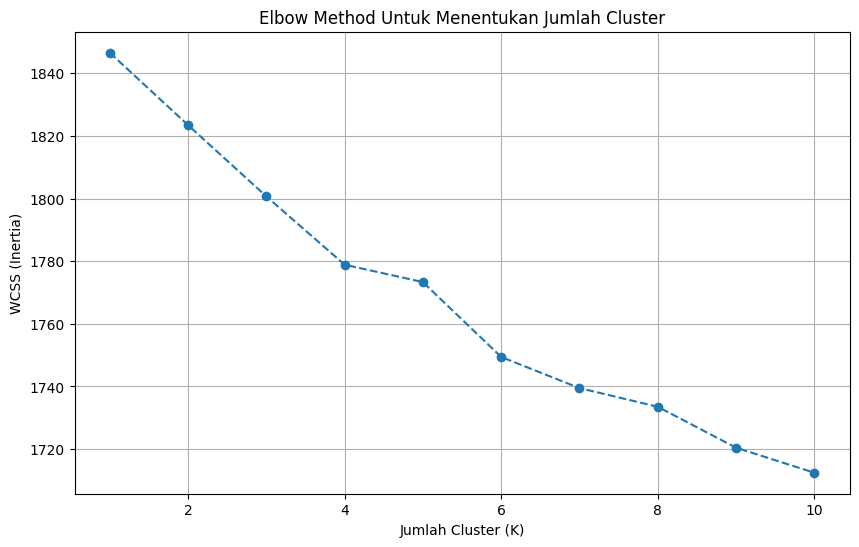

In [33]:
# Elbow Method for K-Means
wcss = []
K_range = range(1, 11)

print("Menghitung Elbow Method...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    wcss.append(kmeans.inertia_)

# Plotting Elbow
plt.figure(figsize=(10,6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method Untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

In [34]:
# Final K-Means Clustering
true_k = 4
kmeans_model = KMeans(n_clusters=true_k, init='k-means++', random_state=42, n_init=10)
kmeans_model.fit(X_tfidf)

df['cluster_kmeans'] = kmeans_model.labels_

print("Contoh hasil clustering:")
print(df[['processed_text', 'cluster_kmeans']].head(10))
print("\nTop words per cluster:")
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]}, ", end="")
    print()

Contoh hasil clustering:
                                      processed_text  cluster_kmeans
0           sehat menkeu untung lindung tuhan aamiin               1
1  negri lumrah jabat mundur nkri inginya pecat m...               1
2          pajak rakyat tekan pajak usaha transfaran               2
3  awas guna anggar ketar tir upaya tolak bijak p...               1
4                                        pimpin laki               1
5             jahat politik takut ganggu duduk hasil               1
6  kalimat habis anggar sungguh muak perintah dae...               1
7                                               cuih               1
8                                          naik gaji               1
9  napa utang kerja sebahagian koropsi penghianat...               1

Top words per cluster:
Cluster 0: guru, beban, negara, rakyat, mulyani, gaji, tri, jasa, murid, pintar, 
Cluster 1: rakyat, mulyani, orang, negara, indonesia, uang, tri, mundur, jabat, prabowo, 
Cluster 2: pajak, ba

In [35]:
# Evaluasi K-Means dengan Silhouette Score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_tfidf, kmeans_model.labels_)
print(f"Silhouette Score untuk K={true_k}: {silhouette_avg:.4f}")

if silhouette_avg > 0.1:
    print("Struktur cluster cukup terlihat.")
elif silhouette_avg > 0.05:
    print("Struktur cluster lemah (data teks seringkali tumpang tindih).")
else:
    print("Cluster sangat tumpang tindih.")

Silhouette Score untuk K=4: 0.0257
Cluster sangat tumpang tindih.


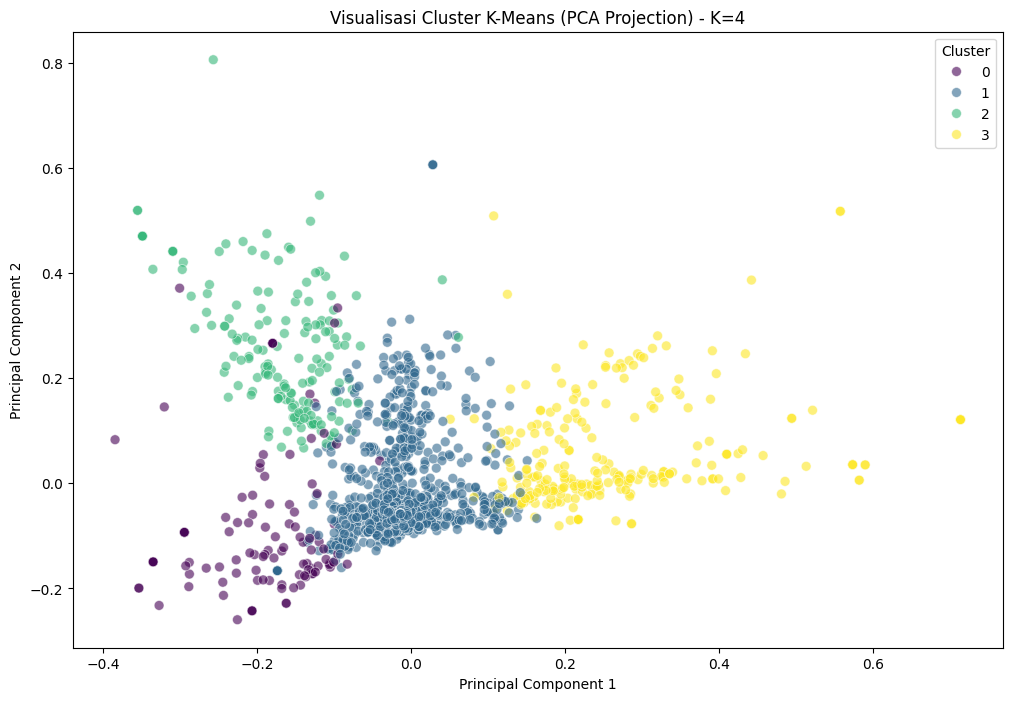

In [36]:
# Visualisasi Scatter Plot (PCA)
from sklearn.decomposition import PCA

# Reduksi dimensi ke 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(X_tfidf.toarray())

# Buat DataFrame untuk plotting
scatter_df = pd.DataFrame(coords, columns=['x', 'y'])
scatter_df['cluster'] = df['cluster_kmeans']

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=scatter_df,
    x='x',
    y='y',
    hue='cluster',
    palette='viridis',
    s=50,
    alpha=0.6
)
plt.title(f'Visualisasi Cluster K-Means (PCA Projection) - K={true_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

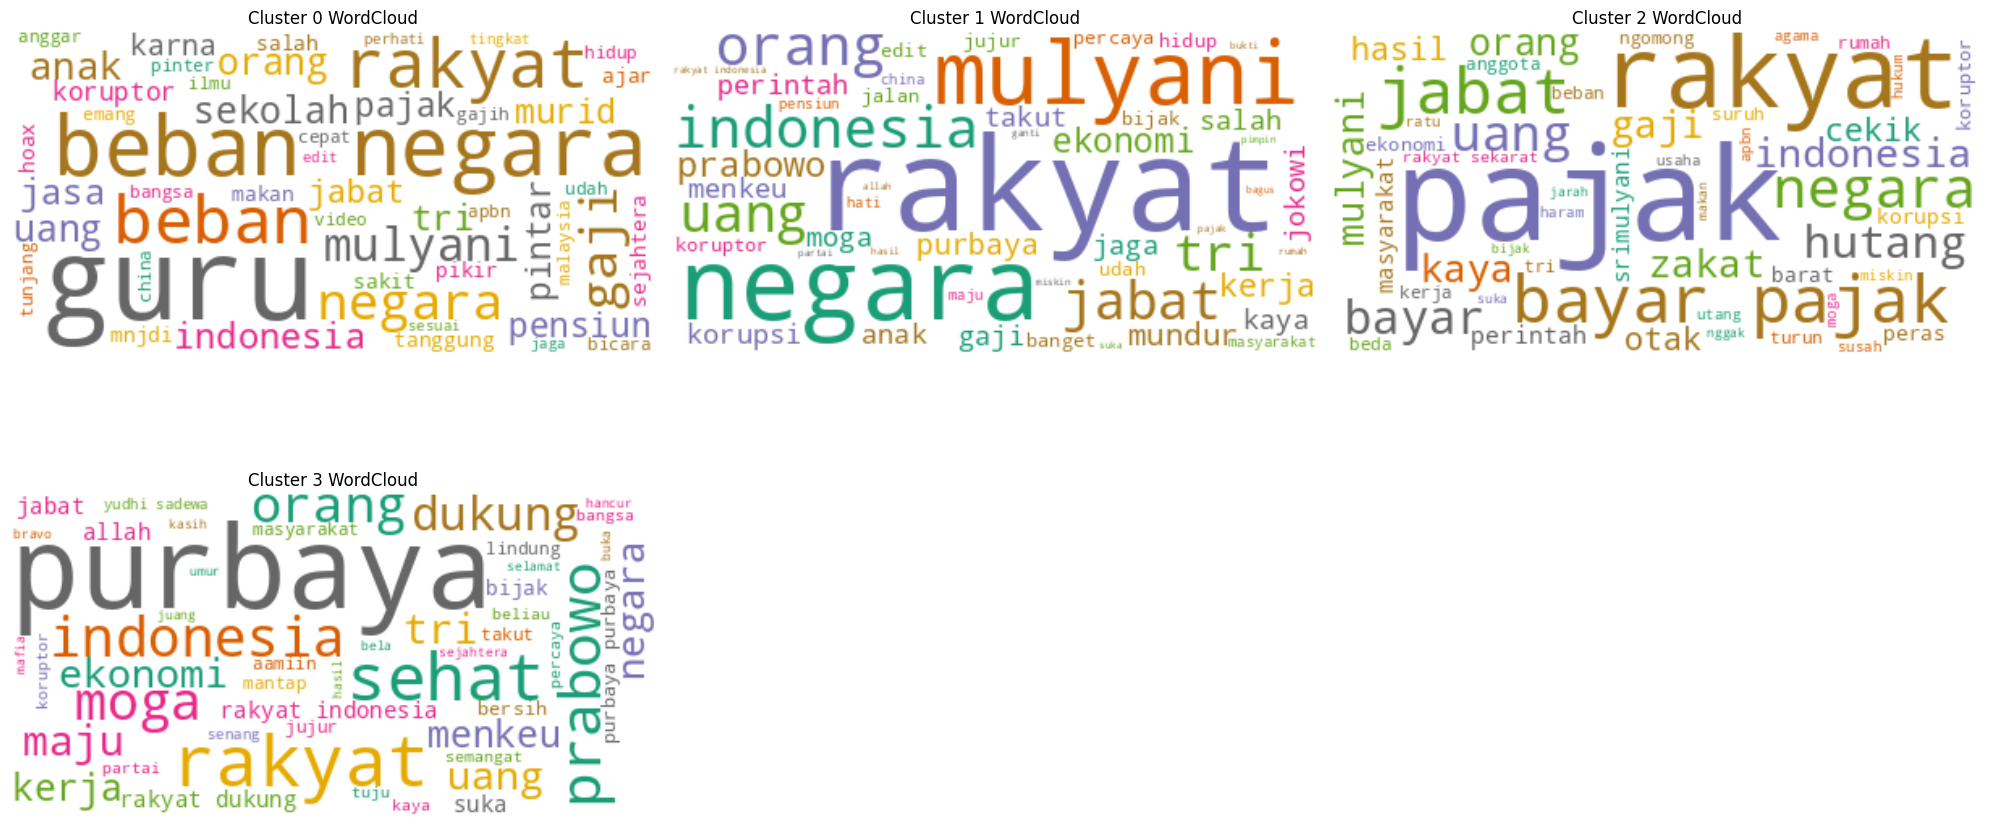

In [37]:
# WordCloud per Cluster
from wordcloud import WordCloud
import math

n_cols = 3 if true_k >= 3 else true_k
n_rows = math.ceil(true_k / n_cols)

plt.figure(figsize=(20, 5 * n_rows))

for i in range(true_k):
    # Ambil semua teks dalam cluster i
    text_cluster = " ".join(df[df['cluster_kmeans'] == i]['processed_text'])

    # Buat WordCloud
    wc = WordCloud(
        background_color='white',
        max_words=50,
        colormap='Dark2',
        stopwords=list_stopwords
    ).generate(text_cluster)

    # Plot
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Cluster {i} WordCloud")
    plt.axis("off")

plt.tight_layout()
plt.show()

Sebaran Sentimen per Cluster:
label           negatif  netral  positif
cluster_kmeans                          
0                    62      24       19
1                   475     571      395
2                   107      46       11
3                    33      43      173


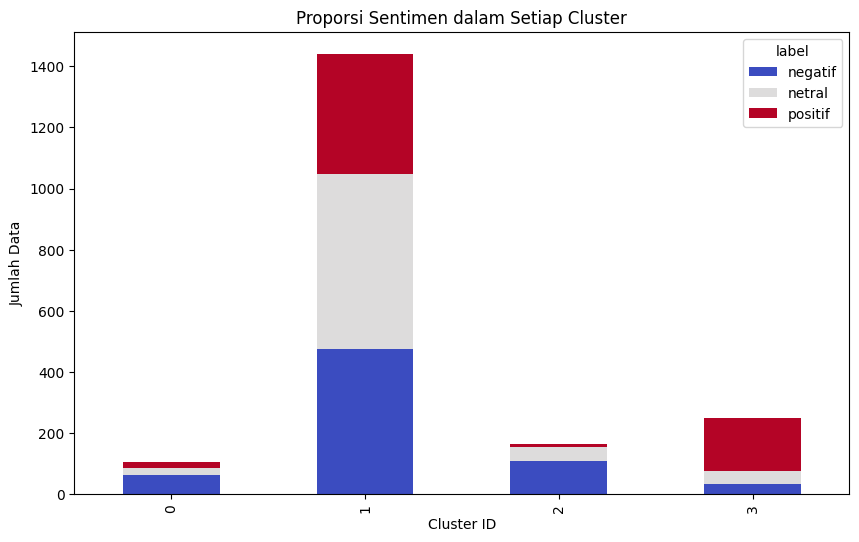

In [38]:
# Analisis Cluster vs Sentimen Label
ct = pd.crosstab(df['cluster_kmeans'], df['label'])
print("Sebaran Sentimen per Cluster:")
print(ct)

# Visualisasi Stacked Bar
ct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Proporsi Sentimen dalam Setiap Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Jumlah Data')
plt.show()